## DM-31341 Analyze COSMOS purity for Rubin 2021 PCW

In [1]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import seaborn as sns
from lsst.ap.association import UnpackApdbFlags#, MapDiaSourceConfig
import lsst.daf.butler as dafButler

from IPython.display import Image, display, HTML

sys.path.append('..')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa
import seaborn as sns

In [2]:
ticket = 'DM-31341'

In [3]:
sns.set_context('poster')

In [4]:
dfzoo = pd.read_csv('../data/DM-31341_alert-production-zoo-classifications.csv')

In [5]:
len(dfzoo)

1682

In [6]:
dfzoo.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,207552876,ebellm,1649740.0,855dd783e4e18cd662b8,13338,Scan cutouts,14.25,2020-03-07 01:13:05 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938231"":{""retired"":null,""diaSourceId"":1764...",40938231
1,207552908,ebellm,1649740.0,855dd783e4e18cd662b8,13338,Scan cutouts,14.25,2020-03-07 01:13:13 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938233"":{""retired"":null,""diaSourceId"":1764...",40938233
2,207553020,ebellm,1649740.0,855dd783e4e18cd662b8,13338,Scan cutouts,14.25,2020-03-07 01:13:44 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938229"":{""retired"":null,""diaSourceId"":1764...",40938229
3,207553077,ebellm,1649740.0,855dd783e4e18cd662b8,13338,Scan cutouts,14.25,2020-03-07 01:14:00 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938219"":{""retired"":null,""diaSourceId"":1764...",40938219
4,207553107,ebellm,1649740.0,855dd783e4e18cd662b8,13338,Scan cutouts,14.25,2020-03-07 01:14:09 UTC,NaN,NaN,"{""source"":""api"",""session"":""ef4df560cf0cb8504df...","[{""task"":""T0"",""task_label"":""How would you desc...","{""40938221"":{""retired"":null,""diaSourceId"":1764...",40938221


In [7]:
dfzoo.columns

Index(['classification_id', 'user_name', 'user_id', 'user_ip', 'workflow_id',
       'workflow_name', 'workflow_version', 'created_at', 'gold_standard',
       'expert', 'metadata', 'annotations', 'subject_data', 'subject_ids'],
      dtype='object')

*It's giving us all classifications, not just the most recent subjet set* -- need to filter

In [8]:
dfzoo['workflow_version'].value_counts()

18.31    918
20.36    708
14.25     40
20.35     15
17.31      1
Name: workflow_version, dtype: int64

I am not sure how these workflow versions are defined, but we want the most recent

In [9]:
dfzoo = dfzoo.loc[dfzoo['workflow_version'] == 20.36].copy()

In [10]:
def get_classification(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[0]['value'])

def get_text_comment(df):
    return dfzoo['annotations'].apply(json.loads).apply(lambda x: x[1]['value'] if (x[0]['value'] == 'Other') else None)

def get_diaSourceId(df):
    return dfzoo['subject_data'].apply(json.loads).apply(lambda x: int(list(x.values())[0]['diaSourceId']))

In [11]:
dfzoo['classification'] = get_classification(dfzoo)
dfzoo['comment'] = get_text_comment(dfzoo)
dfzoo['diaSourceId'] = get_diaSourceId(dfzoo)

match back to the data

In [12]:
repo = '/repo/main'
butler = dafButler.Butler(repo)

In [13]:
collection = 'u/mrawls/DM-31053-HSC-fakes'
dbSchema = 'mrawls_DM31053'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

In [14]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [15]:
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                      dbType='postgres',
                                                      dbName='lsstdevapdb1',
                                                      schema=dbSchema,
                                                      gen='gen3',
                                                      instrument=instrument,
                                                      badFlagList=badFlagList)

In [16]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument=instrument, gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                               badFlagList=badFlagList,
                                                                               gen='gen3', instrument=instrument,
                                                                               repo=repo)


In [17]:
all_flag_names = flagTable.columns

In [18]:
srcTableFlags

,diaSourceId,diaObjectId,ra,decl,ccdVisitId,midPointTai,apFlux,psFlux,apFluxErr,psFluxErr,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
0,5030474002989724,5030474002989724,150.297200,2.992924,2342497,56979.585626,NaN,NaN,NaN,NaN,...,True,True,False,True,True,True,False,False,False,False
1,5030474002989725,5030474002989725,150.297888,2.948913,2342497,56979.585626,NaN,NaN,NaN,NaN,...,False,False,False,False,True,True,False,False,False,False
2,5030474002989726,5030474002989726,150.297994,2.946341,2342497,56979.585626,NaN,NaN,NaN,NaN,...,True,True,False,True,True,True,False,True,False,False
3,5030474002989727,5030474002989727,150.296951,2.971439,2342497,56979.585626,1012.744730,622.227786,95.122208,44.680898,...,False,False,False,False,False,False,False,False,False,False
4,5030474002989728,5030474002989728,150.296481,2.979352,2342497,56979.585626,812.884344,481.819170,96.133277,43.712684,...,False,False,False,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498083,9720393606628107,10181670946734736,150.622397,1.764278,4526411,57049.592447,-1313.467171,1108.608623,522.763001,162.527723,...,False,False,False,False,False,False,False,False,False,False
5498084,9720393606628108,5022556230779480,150.625070,1.781690,4526411,57049.592447,-1493.473314,NaN,641.954735,NaN,...,False,False,False,False,True,False,True,False,False,False
5498085,9720393606628109,12601648794829943,150.623526,1.717551,4526411,57049.592447,-1735.321442,NaN,603.122349,NaN,...,False,False,False,False,True,True,False,False,False,False
5498086,9720393606628110,5022556230779482,150.625343,1.773483,4526411,57049.592447,NaN,NaN,NaN,NaN,...,True,True,False,True,True,True,False,False,False,False


In [19]:
diaSources = pd.merge(srcTableFlags,dfzoo[['classification','comment','diaSourceId']],on='diaSourceId',how='inner')

In [20]:
len(diaSources)

708

<AxesSubplot:xlabel='count', ylabel='classification'>

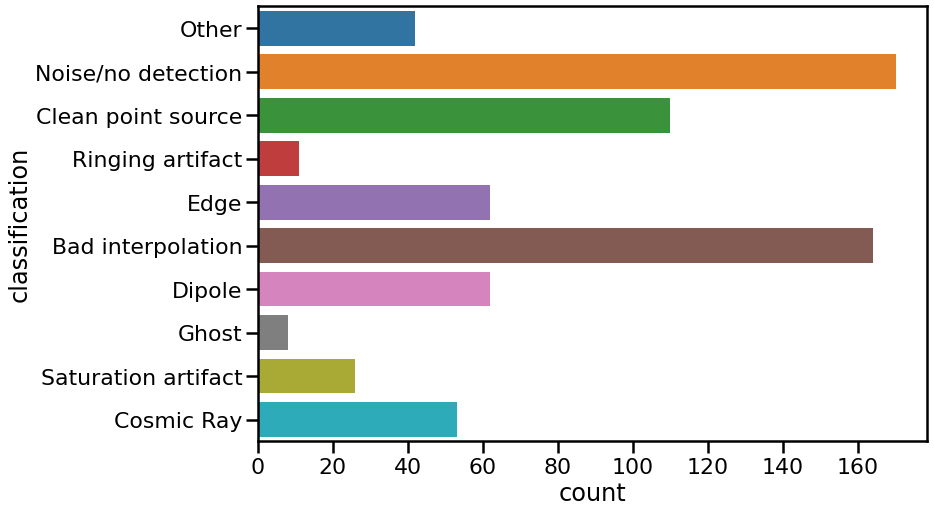

In [21]:
plt.figure(figsize=(12,8))
sns.countplot(data=diaSources,y='classification')
#plt.savefig(f'fig/{ticket}/classification_summary.png', bbox_inches='tight')

In [22]:
flagTable

,base_PixelFlags_flag,base_PixelFlags_flag_offimage,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_saturated,base_PixelFlags_flag_cr,base_PixelFlags_flag_bad,base_PixelFlags_flag_suspect,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_saturatedCenter,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
0,False,False,True,True,False,False,True,False,True,False,...,True,True,False,True,True,True,False,False,False,False
1,False,False,False,True,False,False,True,False,True,False,...,False,False,False,False,True,True,False,False,False,False
2,False,False,False,True,False,True,False,False,False,False,...,True,True,False,True,True,True,False,True,False,False
3,False,False,True,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,True,True,False,False,False,False,True,False,...,False,False,False,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5498083,False,False,False,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5498084,False,False,False,True,False,True,True,False,False,False,...,False,False,False,False,True,False,True,False,False,False
5498085,False,False,False,True,False,False,True,False,False,False,...,False,False,False,False,True,True,False,False,False,False
5498086,False,False,True,True,False,True,True,False,True,False,...,True,True,False,True,True,True,False,False,False,False


<AxesSubplot:>

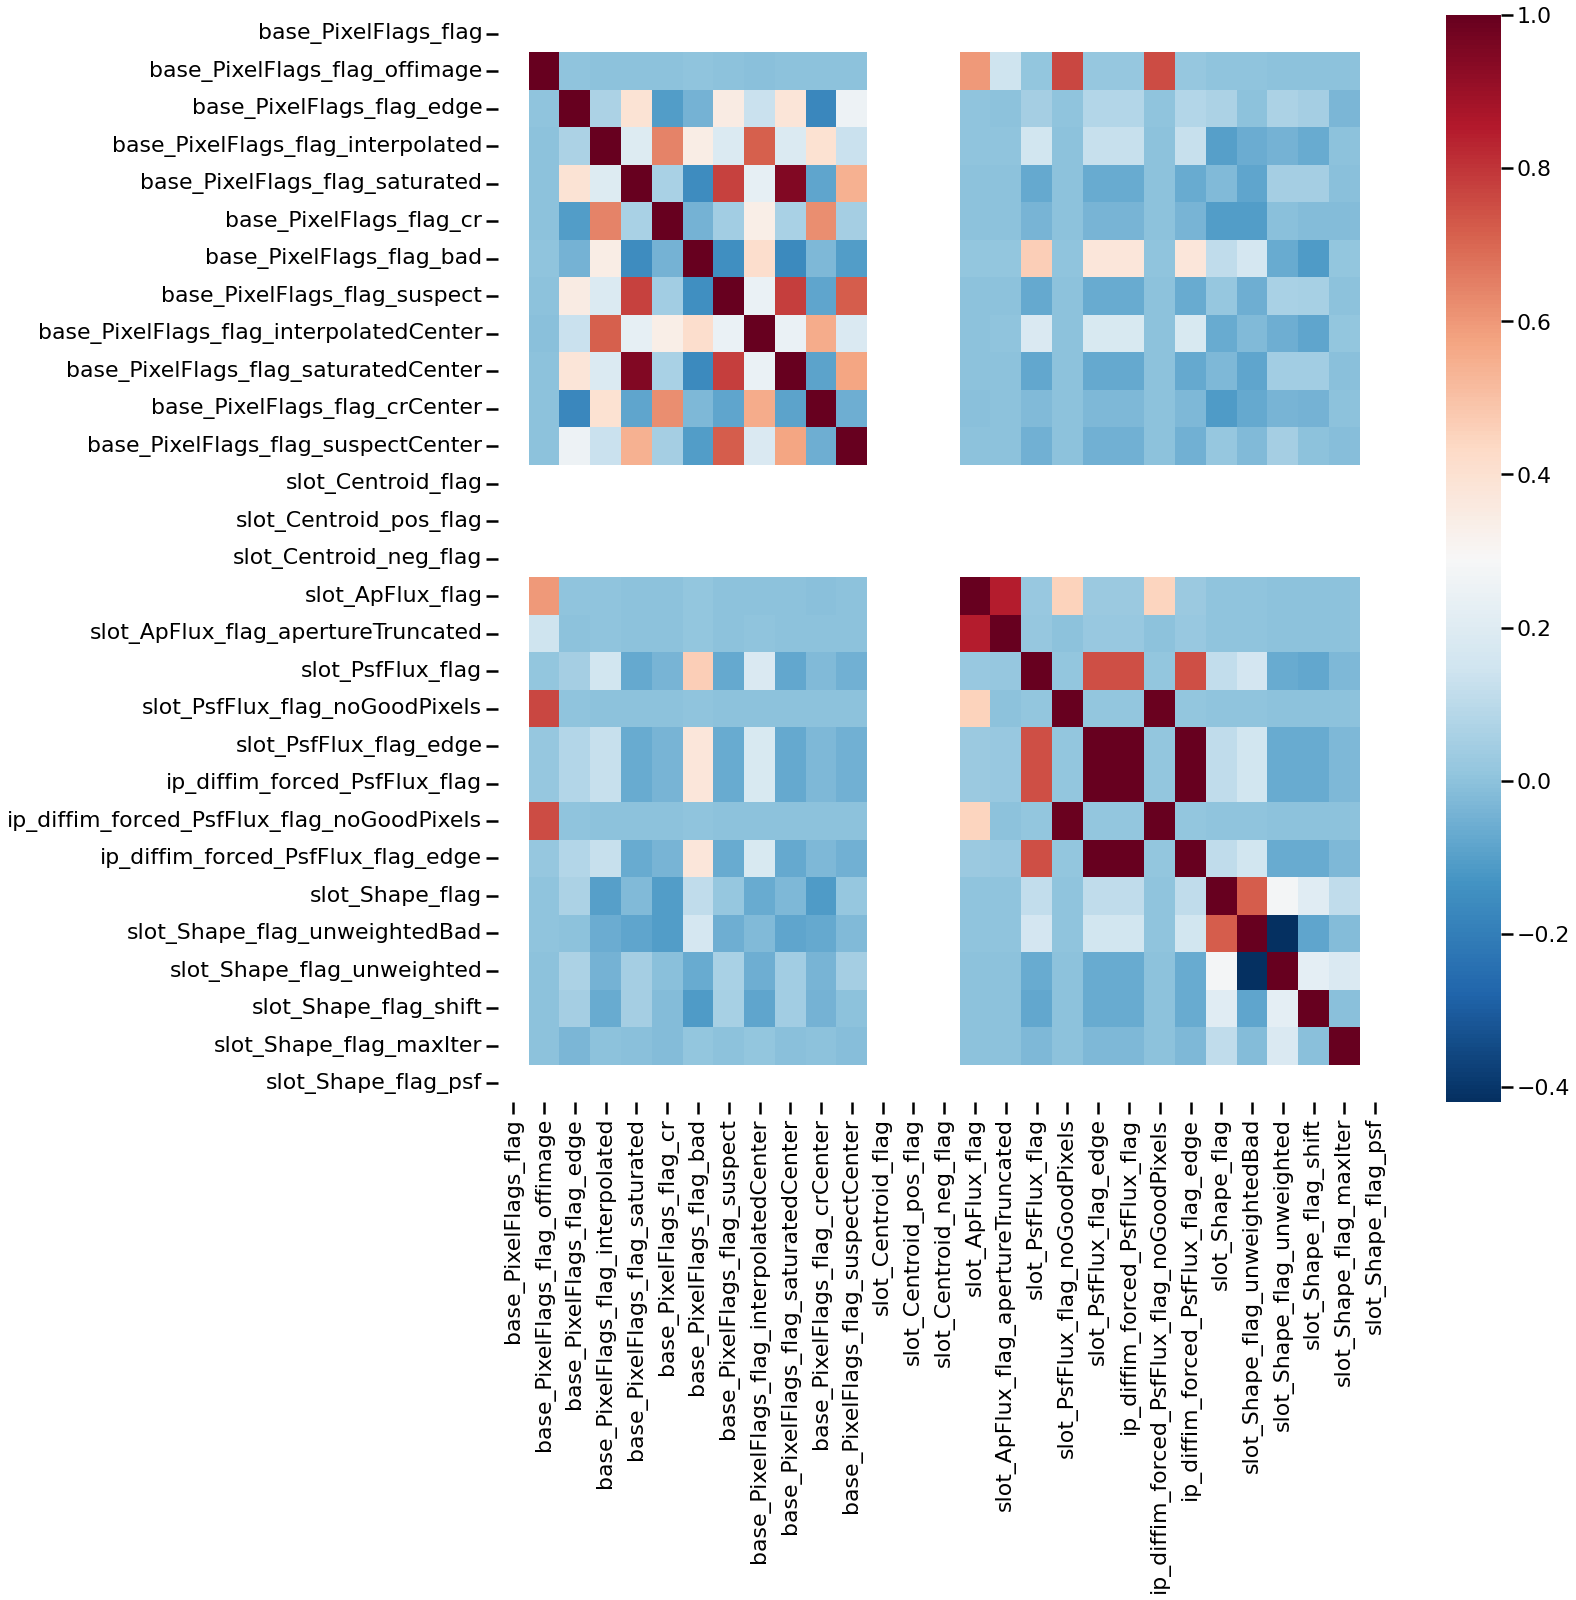

In [23]:
plt.figure(figsize=(20,20))
sns.heatmap(flagTable.corr(),cmap='RdBu_r')

In [24]:
for name in all_flag_names:
    w = diaSources.loc[:,name]
    if np.sum(w):
        print(f"{name}: {np.sum(diaSources.loc[w,'classification'] != 'Clean point source')/np.sum(w):}")

base_PixelFlags_flag_edge: 0.90625
base_PixelFlags_flag_interpolated: 0.8547794117647058
base_PixelFlags_flag_saturated: 0.9487179487179487
base_PixelFlags_flag_cr: 0.8253164556962025
base_PixelFlags_flag_bad: 0.9563106796116505
base_PixelFlags_flag_suspect: 0.9879518072289156
base_PixelFlags_flag_interpolatedCenter: 0.8717391304347826
base_PixelFlags_flag_saturatedCenter: 0.9459459459459459
base_PixelFlags_flag_crCenter: 0.8049792531120332
base_PixelFlags_flag_suspectCenter: 1.0
slot_PsfFlux_flag: 1.0
slot_PsfFlux_flag_edge: 1.0
ip_diffim_forced_PsfFlux_flag: 1.0
ip_diffim_forced_PsfFlux_flag_edge: 1.0
slot_Shape_flag: 0.8852813852813853
slot_Shape_flag_unweightedBad: 0.8650137741046832
slot_Shape_flag_unweighted: 0.967391304347826
slot_Shape_flag_shift: 0.9583333333333334
slot_Shape_flag_maxIter: 0.9


In [25]:
wBadFlagged = diaSources.diaSourceId != diaSources.diaSourceId
for flag in badFlagList:
    wBadFlagged |= diaSources[flag]

In [26]:
np.sum(wBadFlagged)

582

In [27]:
len(diaSources)

708

In [28]:
for name in all_flag_names:
    w = diaSources.loc[:,name] & (~wBadFlagged)
    if np.sum(w):
        print(f"{name}: {np.sum(diaSources.loc[w,'classification'] != 'Clean point source')/np.sum(w):}")

base_PixelFlags_flag_saturated: 1.0
slot_Shape_flag: 0.8210526315789474
slot_Shape_flag_unweightedBad: 0.7916666666666666
slot_Shape_flag_unweighted: 0.9523809523809523
slot_Shape_flag_shift: 0.9285714285714286
slot_Shape_flag_maxIter: 0.8


In [29]:
#for name in all_flag_names:
#    w = diaSources.loc[:,name]
#    if np.sum(w):
#        fig = plt.figure()
#        sns.countplot(data=diaSources.loc[w,:],y='classification')
#        plt.title(name)

In [30]:
classgrp = diaSources.groupby('classification')
flag_pct_byclass = classgrp[all_flag_names].agg(lambda x: (np.sum(x)/len(x)).astype(float))
flag_pct_byclass = flag_pct_byclass.replace(to_replace=False,value=0.)
flag_pct_byclass

,base_PixelFlags_flag,base_PixelFlags_flag_offimage,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_saturated,base_PixelFlags_flag_cr,base_PixelFlags_flag_bad,base_PixelFlags_flag_suspect,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_saturatedCenter,...,slot_PsfFlux_flag_edge,ip_diffim_forced_PsfFlux_flag,ip_diffim_forced_PsfFlux_flag_noGoodPixels,ip_diffim_forced_PsfFlux_flag_edge,slot_Shape_flag,slot_Shape_flag_unweightedBad,slot_Shape_flag_unweighted,slot_Shape_flag_shift,slot_Shape_flag_maxIter,slot_Shape_flag_psf
classification,,,,,,,,,,,,,,,,,,,,,
Bad interpolation,0.0,0.0,0.237805,0.987805,0.310976,0.469512,0.707317,0.286585,0.981707,0.304878,...,0.042683,0.042683,0.0,0.042683,0.676829,0.579268,0.085366,0.042683,0.048780,0.0
Clean point source,0.0,0.0,0.136364,0.718182,0.054545,0.627273,0.081818,0.009091,0.536364,0.054545,...,0.000000,0.000000,0.0,0.000000,0.481818,0.445455,0.027273,0.018182,0.018182,0.0
Cosmic Ray,0.0,0.0,0.132075,0.962264,0.037736,0.924528,0.000000,0.018868,0.792453,0.018868,...,0.000000,0.000000,0.0,0.000000,0.226415,0.094340,0.132075,0.000000,0.056604,0.0
Dipole,0.0,0.0,0.032258,0.580645,0.145161,0.564516,0.016129,0.016129,0.403226,0.145161,...,0.000000,0.000000,0.0,0.000000,0.806452,0.612903,0.177419,0.145161,0.000000,0.0
Edge,0.0,0.0,0.241935,1.000000,0.129032,0.548387,0.887097,0.129032,0.951613,0.112903,...,0.419355,0.419355,0.0,0.419355,0.806452,0.709677,0.096774,0.016129,0.000000,0.0
Ghost,0.0,0.0,0.000000,0.750000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.750000,0.375000,0.375000,0.250000,0.000000,0.0
Noise/no detection,0.0,0.0,0.270588,0.452941,0.058824,0.405882,0.029412,0.023529,0.288235,0.035294,...,0.000000,0.000000,0.0,0.000000,0.770588,0.594118,0.170588,0.123529,0.029412,0.0
Other,0.0,0.0,0.261905,0.928571,0.071429,0.666667,0.333333,0.047619,0.761905,0.095238,...,0.000000,0.000000,0.0,0.000000,0.619048,0.428571,0.190476,0.047619,0.047619,0.0
Ringing artifact,0.0,0.0,0.272727,0.545455,0.454545,0.454545,0.000000,0.181818,0.454545,0.454545,...,0.000000,0.000000,0.0,0.000000,0.545455,0.363636,0.181818,0.090909,0.000000,0.0


<AxesSubplot:ylabel='classification'>

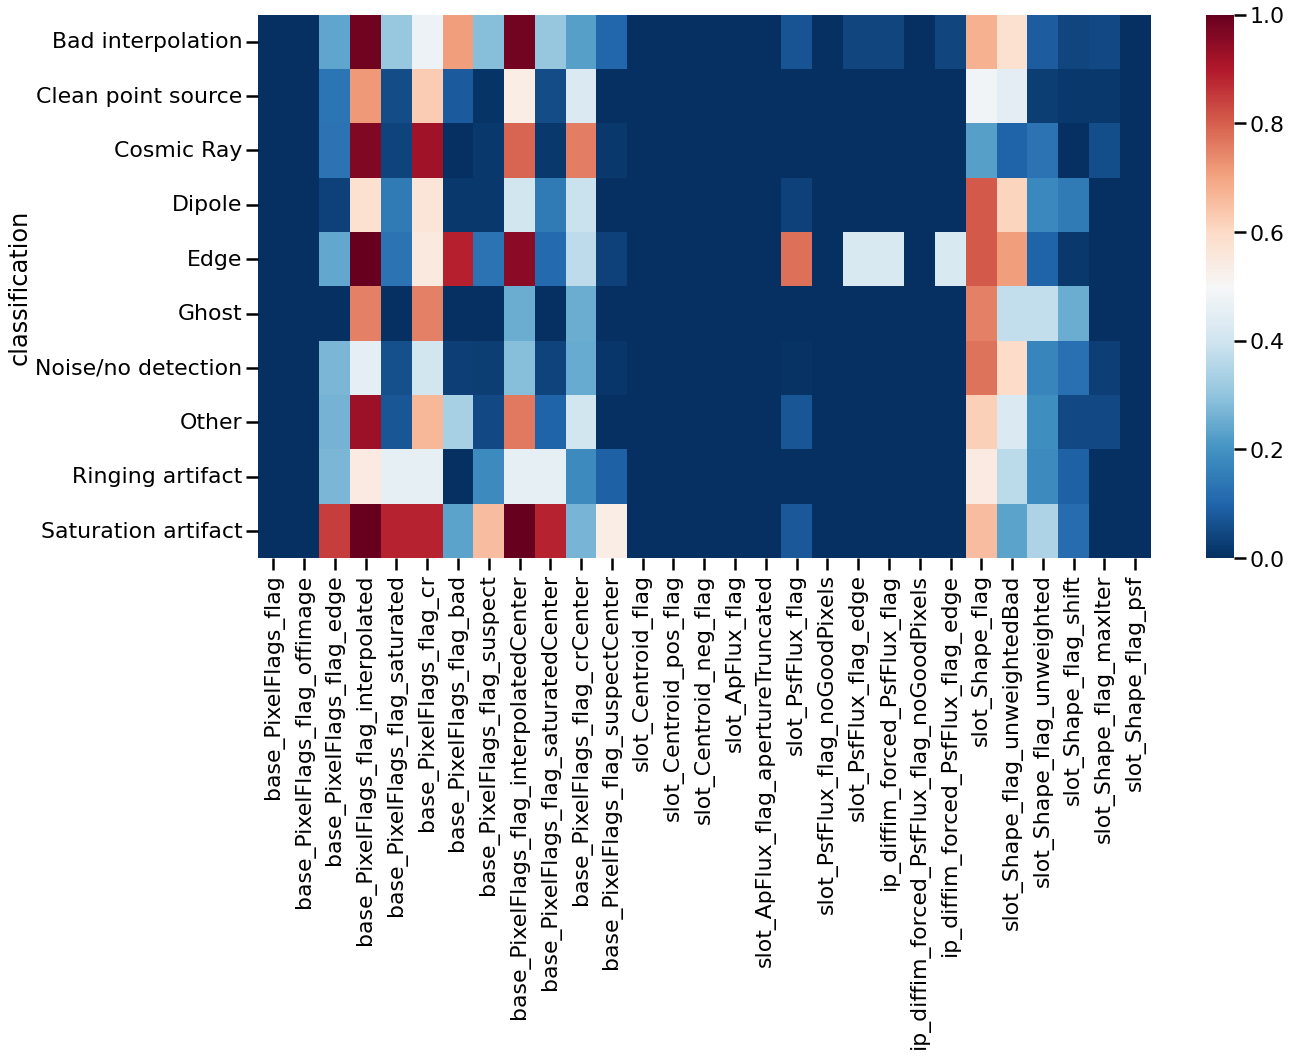

In [31]:
plt.figure(figsize=(20,10))
sns.heatmap(flag_pct_byclass ,cmap='RdBu_r')

In [32]:
badFlagList

['base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_suspect',
 'base_PixelFlags_flag_saturatedCenter',
 'base_PixelFlags_flag_interpolated',
 'base_PixelFlags_flag_interpolatedCenter',
 'base_PixelFlags_flag_edge']

Formal requirements are on SNR > 6 (note these are *measured* SNRs not detected which is why this looks weird)

In [33]:
diaSources['snr'] = diaSources['apFlux']/diaSources['apFluxErr']

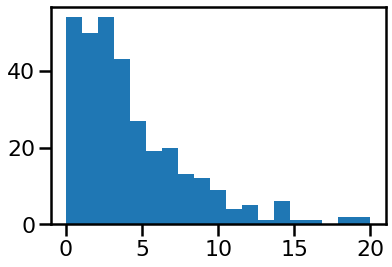

In [34]:
_=plt.hist(diaSources.snr,bins=np.linspace(0,20,20))

In [35]:
wsnrgt6 = diaSources.snr >= 6
np.sum(wsnrgt6)

137

<AxesSubplot:xlabel='count', ylabel='classification'>

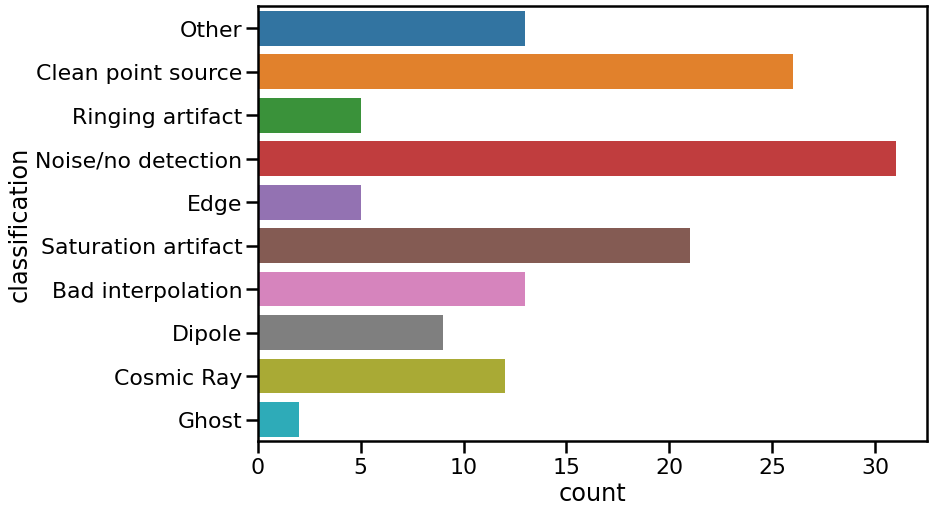

In [36]:
plt.figure(figsize=(12,8))

sns.countplot(data=diaSources.loc[wsnrgt6,:],y='classification')
#plt.savefig(f'fig/{ticket}/classification_summary_6sigma.png', bbox_inches='tight')


<AxesSubplot:xlabel='count', ylabel='classification'>

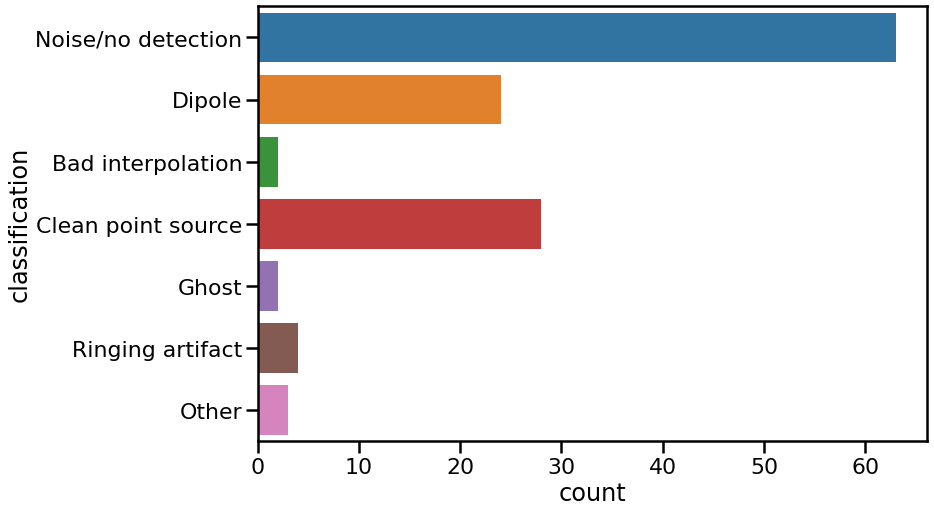

In [37]:
plt.figure(figsize=(12,8))
sns.countplot(data=diaSources.loc[~wBadFlagged,:],y='classification')
#plt.savefig(f'fig/{dataset}/classification_summary_noBadFlags.png', bbox_inches='tight')


artifact to real ratios:

In [38]:
np.sum(wsnrgt6 & ~(diaSources.classification == 'Clean point source')) / \
np.sum(wsnrgt6 & (diaSources.classification == 'Clean point source'))

4.269230769230769

In [39]:
np.sum(~(diaSources.classification == 'Clean point source')) / \
np.sum((diaSources.classification == 'Clean point source'))

5.4363636363636365

In [40]:
np.sum(~wBadFlagged & ~(diaSources.classification == 'Clean point source')) / \
np.sum(~wBadFlagged & (diaSources.classification == 'Clean point source'))

3.5

raw 5-sigma purity:

In [41]:
np.sum((diaSources.classification == 'Clean point source')) / \
len(diaSources)

0.1553672316384181

raw 6-sigma purity:

In [42]:
np.sum(wsnrgt6 & (diaSources.classification == 'Clean point source')) / \
np.sum(wsnrgt6)

0.1897810218978102

5-sigma purity with bad flag rejection:

In [43]:
np.sum(~wBadFlagged & (diaSources.classification == 'Clean point source')) / np.sum(~wBadFlagged)

0.2222222222222222

6-sigma purity with bad flag rejection:

In [44]:
np.sum(~wBadFlagged & wsnrgt6 & (diaSources.classification == 'Clean point source')) / np.sum(~wBadFlagged & wsnrgt6)

0.375

So our standard "bad" flags are not close to getting us to our required completeness and purity.  

A useful next step would be to see if additional flags would improve completeness further.

### Plot cutouts

In [45]:
classifications = diaSources.classification.unique()
classifications

array(['Other', 'Noise/no detection', 'Clean point source',
       'Ringing artifact', 'Edge', 'Bad interpolation', 'Dipole', 'Ghost',
       'Saturation artifact', 'Cosmic Ray'], dtype=object)

In [46]:
#stamp_directory = '/scratch/ebellm/zooniverse/images/'
stamp_directory = 'https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/images/'

In [47]:
for class_name, ids in classgrp[['diaSourceId']].agg(list).iterrows():
    display(HTML(f'<h3>{class_name}</h3>'))
    idl = ids.tolist()[0]
    filenames = [f'{stamp_directory}/{idi}.png' for idi in idl]
    imagesList=''.join( ["<img style='width: 300px; margin: 0px; float: left; border: 0px solid black;' src='%s' />" % str(s) 
                     for s in sorted(filenames) ])
    display(HTML(imagesList))

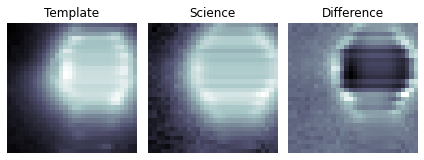

In [48]:
display(Image(filenames[0]))

### Edge examination.
Are the edge-labeled cutouts actually on the edge, or are we getting confused by interpolation?

In [49]:
wFlagEdge = diaSources.base_PixelFlags_flag_edge

In [50]:
np.sum(wFlagEdge)

160

Text(0.5, 1.0, 'base_PixelFlags_flag_edge set')

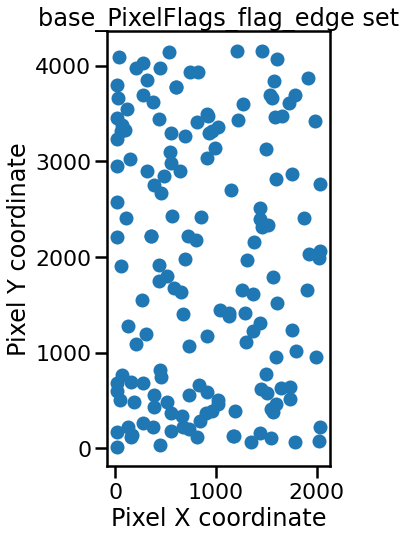

In [63]:
plt.figure(figsize=(4,8))
plt.scatter(diaSources.loc[wFlagEdge,'x'],diaSources.loc[wFlagEdge,'y'])
plt.xlabel('Pixel X coordinate')
plt.ylabel('Pixel Y coordinate')
plt.title('base_PixelFlags_flag_edge set')

.. that seems pretty strange--maybe it's coming through on the template, though?

In [54]:
wLabelEdge = diaSources.classification == 'Edge'

In [55]:
np.sum(wLabelEdge)

62

Text(0.5, 1.0, 'Human-labelled "Edge"')

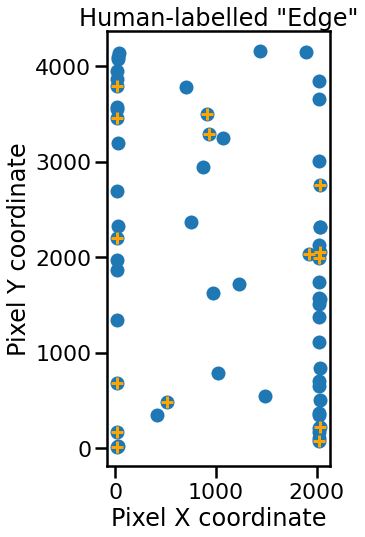

In [69]:
plt.figure(figsize=(4,8))
plt.scatter(diaSources.loc[wLabelEdge,'x'],diaSources.loc[wLabelEdge,'y'])
plt.scatter(diaSources.loc[wLabelEdge & wFlagEdge,'x'],diaSources.loc[wLabelEdge & wFlagEdge,'y'], color='orange', marker='+')

plt.xlabel('Pixel X coordinate')
plt.ylabel('Pixel Y coordinate')
plt.title('Human-labelled "Edge"')

So in fact our human-edge labels are much **more** accurate than the pixel flags at catching these.

Most of our "edge" labels don't have the edge flag set, and most of the edge-flagged DIASources we don't classify as edge.

### Nondetections

What can we learn about the nondetections?

In [70]:
diaSources.columns

Index(['diaSourceId', 'diaObjectId', 'ra', 'decl', 'ccdVisitId', 'midPointTai',
       'apFlux', 'psFlux', 'apFluxErr', 'psFluxErr', 'totFlux', 'totFluxErr',
       'x', 'y', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'filterName', 'visit',
       'ccd', 'base_PixelFlags_flag', 'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated',
       'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_cr',
       'base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter', 'slot_Centroid_flag',
       'slot_Centroid_pos_flag', 'slot_Centroid_neg_flag', 'slot_ApFlux_flag',
       'slot_ApFlux_flag_apertureTruncated', 'slot_PsfFlux_flag',
       'slot_PsfFlux_flag_noGoodPixels', 'slot_PsfFlux_flag_edge',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_fl

In [71]:
wLabelNondet = diaSources.classification == 'Noise/no detection'

Text(0.5, 1.0, 'Human-labelled "Nondetection"')

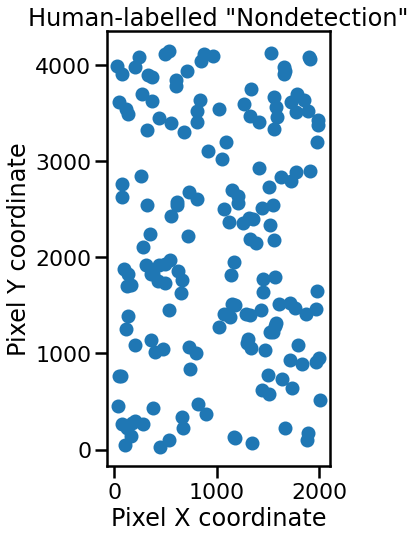

In [72]:
plt.figure(figsize=(4,8))
plt.scatter(diaSources.loc[wLabelNondet,'x'],diaSources.loc[wLabelNondet,'y'])

plt.xlabel('Pixel X coordinate')
plt.ylabel('Pixel Y coordinate')
plt.title('Human-labelled "Nondetection"')

In [74]:
diaSources.loc[wLabelNondet,'ccdVisitId'].value_counts()

4528862    3
3585222    2
4740896    2
376015     2
3586062    2
          ..
3938897    1
6098002    1
2338899    1
3580501    1
3588863    1
Name: ccdVisitId, Length: 163, dtype: int64

So no clear trends in `x`/`y` pixel coordinates, and there are a few in every CCD/visit without being dominant in any.

Text(0.5, 1.0, 'Measured psFlux SNR')

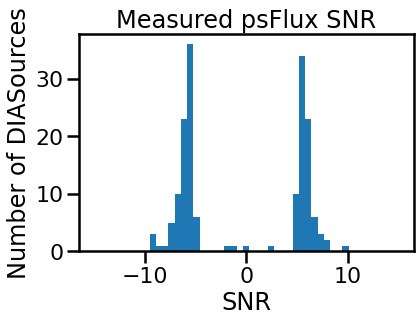

In [91]:
_ = plt.hist(diaSources.loc[wLabelNondet,'psFlux']/diaSources.loc[wLabelNondet,'psFluxErr'],bins=np.linspace(-15,15,50))
plt.xlabel('SNR')
plt.ylabel('Number of DIASources')
plt.title('Measured psFlux SNR')

Text(0.5, 1.0, 'Measured apFlux SNR')

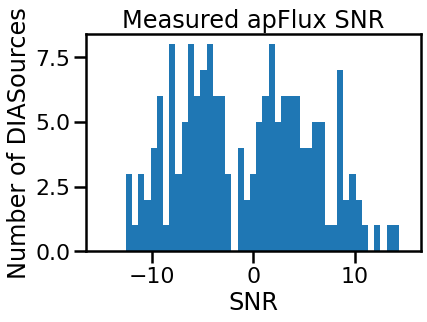

In [93]:
_ = plt.hist(diaSources.loc[wLabelNondet,'apFlux']/diaSources.loc[wLabelNondet,'apFluxErr'],bins=np.linspace(-15,15,50))
plt.xlabel('SNR')
plt.ylabel('Number of DIASources')
plt.title('Measured apFlux SNR')

Text(0.5, 1.0, 'Measured totFlux SNR')

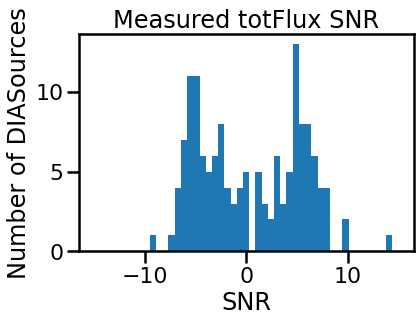

In [92]:
_ = plt.hist(diaSources.loc[wLabelNondet,'totFlux']/diaSources.loc[wLabelNondet,'totFluxErr'],bins=np.linspace(-15,15,50))
plt.xlabel('SNR')
plt.ylabel('Number of DIASources')
plt.title('Measured totFlux SNR')

So this is surprising and pretty interesting!  We don't (yet) have the *detection* SNR stored (see DM-31811), but the measured `psFlux` SNR is about as close a proxy as we have.  And it looks like these are indeed claiming to be greater than SNR of 5.  That is surprising when we look at the images, and the aperture SNRs being lower suggest that it's a weird interaction of the PSF model and the variance plane, maybe?  I think we have to plot the variance planes to tell.

Text(0.5, 0, 'Measured apFlux SNR')

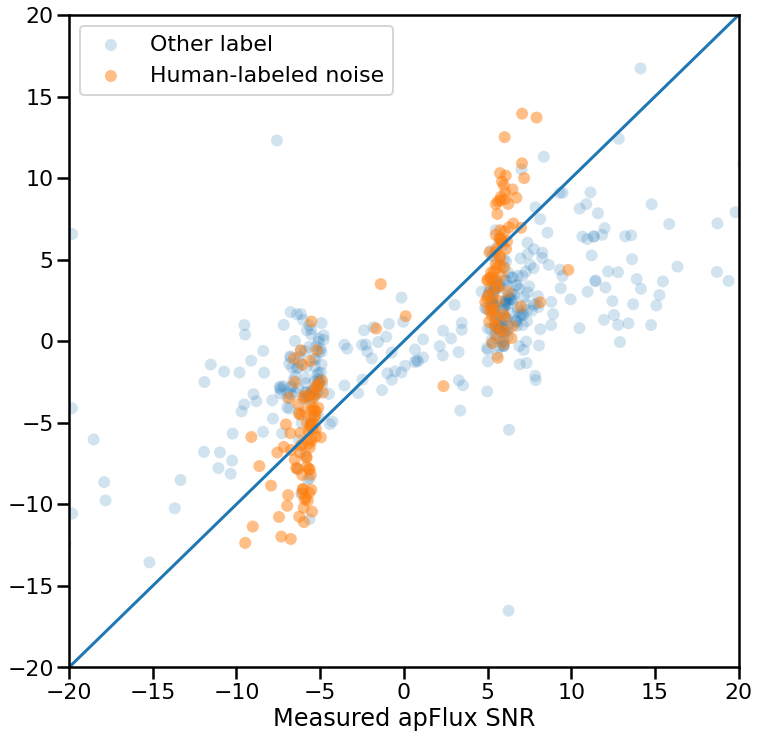

In [103]:
plt.figure(figsize=(12,12))
_ = plt.scatter(diaSources.loc[~wLabelNondet,'psFlux']/diaSources.loc[~wLabelNondet,'psFluxErr'],
                diaSources.loc[~wLabelNondet,'apFlux']/diaSources.loc[~wLabelNondet,'apFluxErr'], alpha=0.2,edgecolor='none',label='Other label')
_ = plt.scatter(diaSources.loc[wLabelNondet,'psFlux']/diaSources.loc[wLabelNondet,'psFluxErr'],
                diaSources.loc[wLabelNondet,'apFlux']/diaSources.loc[wLabelNondet,'apFluxErr'], alpha=0.5,edgecolor='none',label='Human-labeled noise')
plt.legend()
plt.plot([-20,20],[-20,20])
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.xlabel('Measured psFlux SNR')
plt.xlabel('Measured apFlux SNR')